<a href="https://colab.research.google.com/github/jvallikivi/mlmi4-vcl/blob/main/Generative_MNIST_TEST_LL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.distributions import kl_divergence, Normal
from collections import OrderedDict
from torchvision import datasets
from torchvision import transforms

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 0.001
batch_size = 50
n_epochs = 200

In [ ]:
class BayesLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight_loc = nn.Parameter(torch.zeros(in_features, out_features))
        self.log_weight_scale = nn.Parameter(torch.zeros(in_features, out_features))

        self.bias_loc = nn.Parameter(torch.zeros(out_features))
        self.log_bias_scale = nn.Parameter(torch.zeros(out_features))
        
        self.weight = self.weight_loc.data.clone().to(device)
        self.bias = self.bias_loc.data.clone().to(device)



    def get_params(self):
        """
        return two tensors, obtaining by concatenating locs and scales together
        these parameters can be further used to calculate e.g, KL divergence (vectorizedly)
        """
        return (
                torch.cat([self.weight_loc.flatten(), self.bias_loc.flatten()]), 
                torch.cat([self.log_weight_scale.flatten(), self.log_bias_scale.flatten()])
               )

    
    def forward(self, x,  activition_fn=None):

        y = x @ self.weight + self.bias
        if activition_fn:
            return activition_fn(y)
        return y


In [ ]:
class Encoder(nn.Module):

    def __init__(self, 
                 input_size, 
                 in_features, 
                 out_features, 
                 n_layers,                 ):
        """
        """
        super(Encoder, self).__init__()
        self.x_to_h = nn.ModuleList( [self.get_layer(input_size, in_features, True)] + 
                                    [self.get_layer(in_features, in_features, True) for _ in range(n_layers - 1)]).to(device)
        self.head = nn.ModuleList([self.get_layer(in_features, out_features, True) for _ in range(n_layers - 1)]
                                    + [self.get_layer(in_features, out_features)]).to(device)


    def get_layer(self, in_feature, out_features, activation=False):
        layer = nn.Linear(in_feature, out_features)
        return layer

In [ ]:
class VCL_Generator(nn.Module):
    def __init__(self, previous_model, 
                 nencoder_layers=3, ndecoder_layers=1, 
                 z_dim=50, h_dim=500, x_dim=784, random_initialize=False):
        super().__init__()
        
        self.ndecoder_layers = ndecoder_layers
        self.z_dim = z_dim

        #######ENCODER PART

        self.encoder = Encoder(input_size=x_dim,
                                in_features=h_dim,
                                out_features=z_dim*2,
                                n_layers=nencoder_layers).to(device)
        self.x_to_h = self.encoder.x_to_h#.to(device)
        self.encoder_head = self.encoder.head[-1]#.to(device)

        ######GENERATOR PART


        self.decoder_head = nn.ModuleList([BayesLinear(z_dim, h_dim)] +
                                          [BayesLinear(h_dim, h_dim) for _ in range(self.ndecoder_layers)]).to(device) 
        self.h_to_x = nn.ModuleList([BayesLinear(h_dim, h_dim) for _ in range(self.ndecoder_layers)] +
                                    [BayesLinear(h_dim, x_dim)]).to(device)
        
        
        # define a layer dict
        self.layer_dict = OrderedDict()
        for ix, layer in enumerate(self.x_to_h):
            self.layer_dict[f'x_to_h_{ix}'] = layer

        for ix, layer in enumerate(self.h_to_x):
            self.layer_dict[f'h_to_x_{ix}'] = layer
        
        for ix, layer in enumerate(self.decoder_head):
            self.layer_dict[f'decoder_head_{ix}'] = layer

        self.layer_dict["encoder_head"] = self.encoder_head

        # just a sanity check 
        assert id(self.layer_dict[f"x_to_h_{0}"]) == id(self.x_to_h[0])
        
        
        with torch.no_grad():
            if previous_model != None:
                for key in self.layer_dict:
                    if "decoder_head" in key or "h_to_x" in key:
                        self.layer_dict[key].weight_loc.data = previous_model.layer_dict[key].weight_loc.data.clone()
                        self.layer_dict[key].bias_loc.data = previous_model.layer_dict[key].bias_loc.data.clone()
                        self.layer_dict[key].log_weight_scale.data  = previous_model.layer_dict[key].log_weight_scale.data.clone()
                        self.layer_dict[key].log_bias_scale.data  = previous_model.layer_dict[key].log_bias_scale.data.clone()
                    else:
                        self.layer_dict[key] = previous_model.layer_dict[key]
            if random_initialize:
                for layer in self.h_to_x + self.decoder_head:
                    layer.log_weight_scale = nn.Parameter(torch.ones(layer.log_weight_scale.shape, device=device) * -6)
                    layer.log_bias_scale = nn.Parameter(torch.ones(layer.log_bias_scale.shape, device=device) * -6)
                    torch.nn.init.xavier_uniform_(layer.weight_loc)
        
        if  previous_model != None:
            previous_locs, previous_logscales = previous_model.get_params()
            self.previous_model_locs = previous_locs
            self.previous_model_log_scales = previous_logscales
        else:
            self.previous_model_locs = None
            self.previous_model_log_scales = None


    def encoder_forward(self, x):
        for layer in self.x_to_h:
            x = layer(x)
            x = nn.ReLU()(x)
        o = self.encoder_head(x)
        return o[:, :self.z_dim], o[:, self.z_dim:]

    
    def decoder_forward(self, z, sampling=False):
        size = len(self.decoder_head + self.h_to_x)
        
        for ix, layer in enumerate(self.decoder_head + self.h_to_x):
            if sampling:
                layer.weight = torch.randn_like(layer.weight_loc) * torch.exp(layer.log_weight_scale) + layer.weight_loc
                layer.bias = torch.randn_like(layer.bias_loc) * torch.exp(layer.log_bias_scale) + layer.bias_loc
            z = layer(z, nn.Sigmoid())
        return z


    def get_params(self):  
        locs = []
        logscales = []
        for layer in self.h_to_x:
            loc, scale = layer.get_params()
            locs.append(loc)
            logscales.append(scale)
        return locs, logscales

    def calculate_loss(self, x, y, n_particles=10, dataset_size=6000):
        
        locs, logscales = self.get_params()
        # calculate KL between "prior" and posterior
        size = len(locs)
        kl = 0
        for ix in range(size):
            KL = kl_divergence(Normal(loc=locs[ix], scale=torch.exp(logscales[ix])),
                                Normal(loc=self.previous_model_locs[ix], scale=torch.exp(self.previous_model_log_scales[ix]))
                            )
            kl += KL.sum()/dataset_size 

        loc, log_scale = self.encoder_forward(x) 
        kl_z = kl_divergence(Normal(loc, torch.exp(log_scale)), 
                             Normal(0., torch.exp(torch.Tensor([0.]).to(device))))
        bce = 0.
        for _ in range(n_particles):
            z = torch.randn_like(loc) * torch.exp(log_scale) + loc
            gen = self.decoder_forward(z, sampling=True)
            bce = bce + torch.nn.functional.binary_cross_entropy(input=gen, target=x, reduction="sum")
            

        loss = (kl_z.sum() + bce / n_particles) / x.shape[0] + kl
        return loss  

In [ ]:
## dataset
ds_test = datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)
ds_train = datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True)

def get_digit(task_idx=0, conv=False):
    #image normalization 255
    train_y = torch.tensor([d[1] for d in ds_train])
    test_y = torch.tensor([d[1] for d in ds_test])

    train_mask = train_y == task_idx
    test_mask = test_y == task_idx

    train_y = train_y[train_mask]
    test_y = test_y[test_mask]

    test_x = nn.Flatten()(torch.cat([d[0] for d in ds_test]))[test_mask]
    train_x = nn.Flatten()(torch.cat([d[0] for d in ds_train]))[train_mask]

    return train_x.to(device), train_y.to(device), test_x.to(device), test_y.to(device)

In [ ]:
# I used their evaluation function and adjusted for torch for consistency
def gaussian_prob(x, loc=0., log_scale=torch.Tensor([0.]).to(device)):
    p1 = -torch.log(torch.Tensor([2 * torch.pi]).to(device))/2 + log_scale
    p2 = -(x - loc)/(2*(torch.exp(log_scale)**2))
    prob = (p1 + p2).sum(1) 
    return prob


def bernoulli_prob(x, p=torch.Tensor([0.5]).to(device)):
    p1 = x * torch.log(torch.clamp(p, 1e-9, 1.0))
    p2 = (1 - x) * torch.log(torch.clamp(1.0 - p, 1e-9, 1.0))
    prob = (p1 + p2).sum(1)

    return prob

def evaluate(model, test_batch):
    test_batch = test_batch.repeat(100, 1)
    loc, log_scale = model.encoder_forward(test_batch) 
    z = torch.randn_like(loc) * torch.exp(log_scale) + loc
    gen = model.decoder_forward(z, sampling=True)
    kl =  gaussian_prob(z, loc, log_scale) - gaussian_prob(z)
    bce = bernoulli_prob(test_batch, gen)
    test_ll = (bce - kl).reshape((100, batch_size))
    max = test_ll.max(0)[0]
    test_ll = torch.clamp_min(test_ll - max, 1e-9) + max
    mean = test_ll.mean()
    var = ((test_ll - mean) ** 2).mean()
    return mean, var

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/models_mnist/

Mounted at /content/drive/
/content/drive/MyDrive/models_mnist


In [ ]:
import os, copy
def calculate_digit_ll(digit_num):
    _, _, test_x, _ = get_digit(digit_num)

    model = VCL_Generator(previous_model=None)
    model.load_state_dict(torch.load(f"model_task{digit_num}"))
    nbatches = test_x.shape[0] // batch_size
    lls = []
    ll_total = 0.
    for batch in range(nbatches):
        batch_idx0 = batch * batch_size
        batch_idx1 = batch * batch_size + batch_size
        ll, _ = evaluate(model, test_x[batch_idx0: batch_idx1])
        ll_total += ll/nbatches

    lls.append(ll_total.detach().item())
    
    for i in range(digit_num+1, 10, 1):
        model1 = VCL_Generator(previous_model=None)
        model1.load_state_dict(torch.load(f"model_task{i}"))
        model.h_to_x = copy.copy(model1.h_to_x)
        ll_total = 0.
        for batch in range(nbatches):
            batch_idx0 = batch * batch_size
            batch_idx1 = batch * batch_size + batch_size
            ll, _ = evaluate(model, test_x[batch_idx0: batch_idx1])
            ll_total += ll/nbatches
        lls.append(ll_total.detach().item())

    return lls

In [ ]:
from collections import defaultdict
test_ll_dict = defaultdict(list)
for i in tqdm(range(10)):
    test_ll_dict[i] = calculate_digit_ll(i)

100%|██████████| 10/10 [02:15<00:00, 13.52s/it]


In [ ]:
test_ll_dict

defaultdict(list,
            {0: [-108.60016632080078,
              -115.08160400390625,
              -123.88758850097656,
              -135.08119201660156,
              -150.90213012695312,
              -157.54884338378906,
              -158.64254760742188,
              -165.82843017578125,
              -184.61346435546875,
              -178.95260620117188],
             1: [-26.636804580688477,
              -30.113033294677734,
              -35.62119674682617,
              -41.377723693847656,
              -47.58979034423828,
              -51.93619155883789,
              -61.62144088745117,
              -57.986812591552734,
              -55.17028045654297],
             2: [-127.9538345336914,
              -136.64837646484375,
              -162.5432586669922,
              -176.5924072265625,
              -173.04620361328125,
              -182.23989868164062,
              -179.76364135742188,
              -178.5758514404297],
             3: [-102.680221557617

In [ ]:
avg_dict = defaultdict(list)
for ix in range(10):
    avg_dict[ix].append(test_ll_dict[ix][0])
    for ix1 in range(1, ix + 1):
        avg_dict[ix].append(test_ll_dict[ix - ix1][ix1])

In [ ]:
for ix in range(10):
    print(ix, f"avg: {np.mean(avg_dict[ix])}")

0 avg: -108.60016632080078
1 avg: -70.85920429229736
2 avg: -93.98481877644856
3 avg: -102.50774669647217
4 avg: -109.69359130859375
5 avg: -114.0119145711263
6 avg: -109.87803486415318
7 avg: -108.53316593170166
8 avg: -108.41708458794488
9 avg: -104.26287956237793


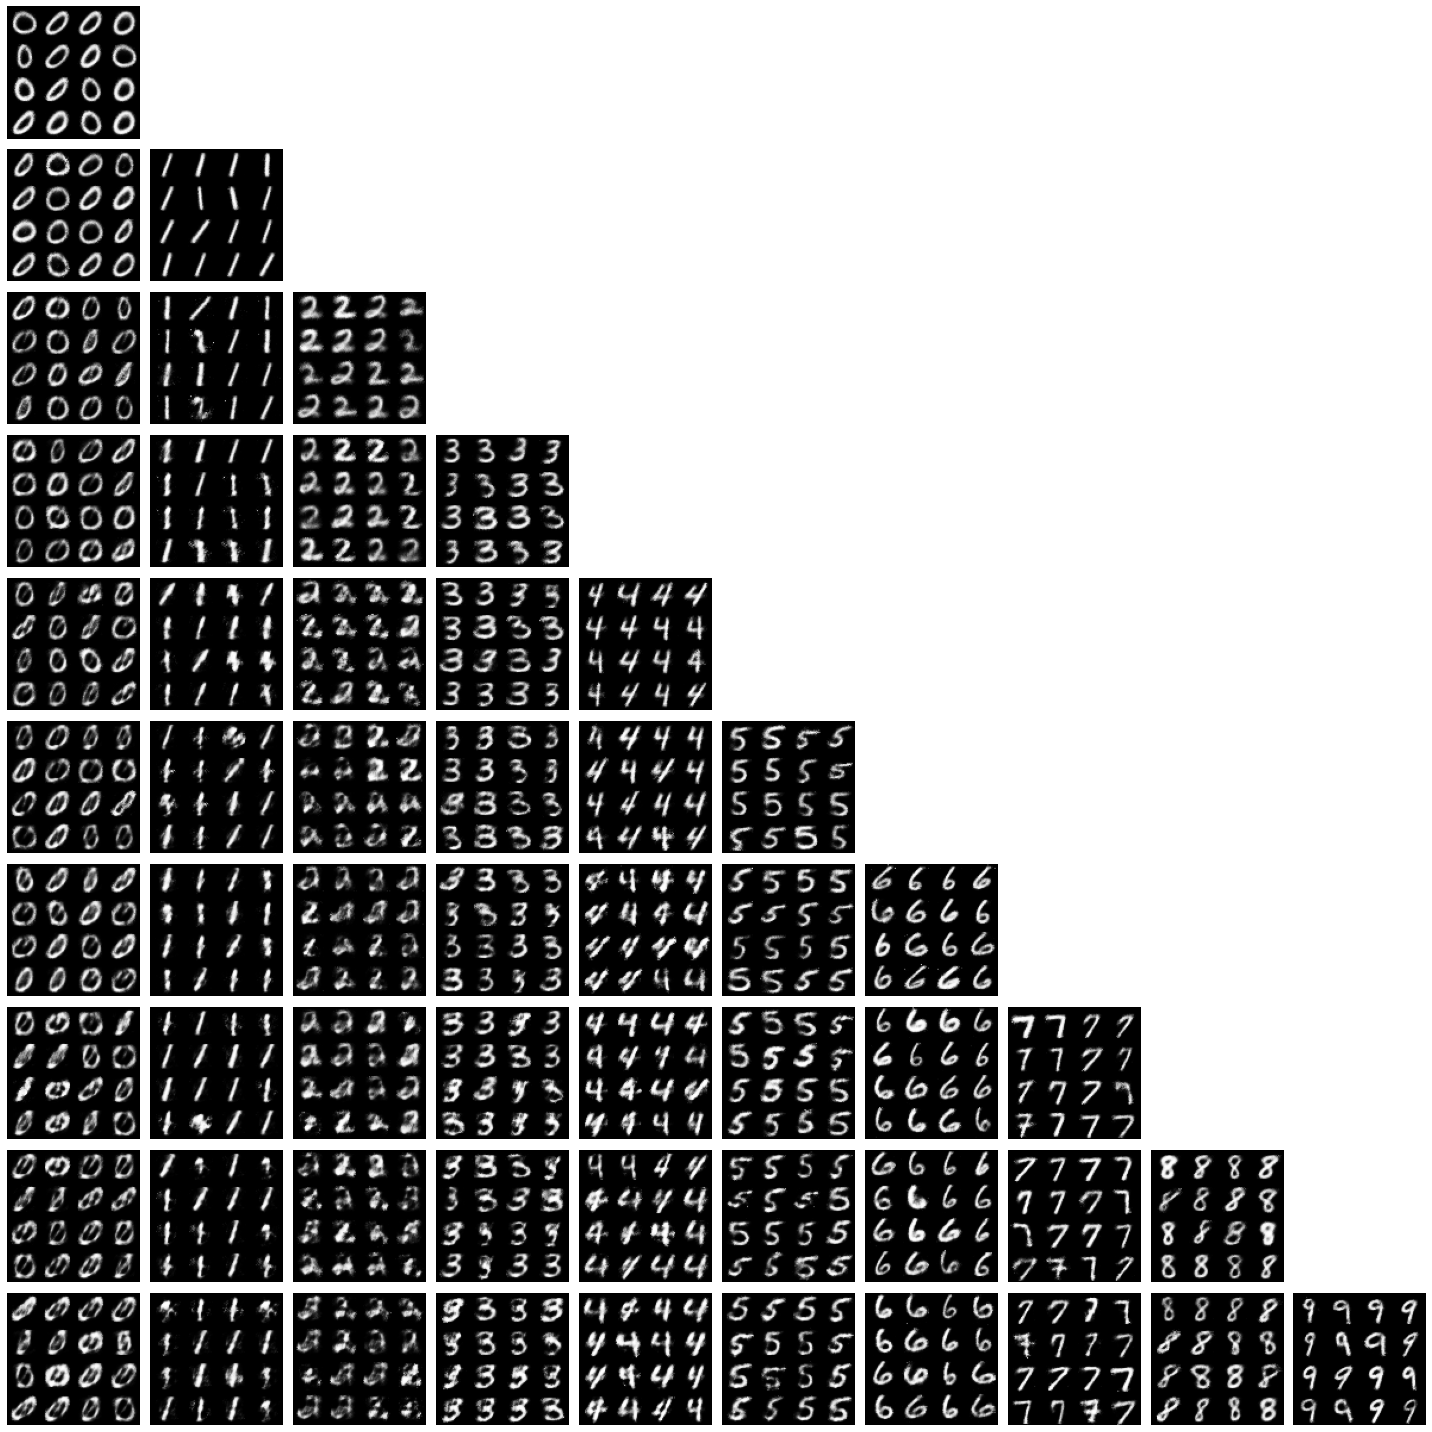

In [ ]:
nrows, ncols = 10, 10
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
for i in range(nrows):
    for j in range(ncols):
        axes[i, j].axis('off')
fig.tight_layout()
for ix1, model1 in enumerate(models):
    cnt = 0
    z = torch.randn(16, 50).to(device)
    image = generate_image(model1.decoder_head, model1.h_to_x, z)
    axes[cnt+ix1, ix1].imshow(image, cmap="gray")
    axes[cnt+ix1, ix1].axis('off')

    for ix2, model2 in enumerate(models[ix1+1:]):
        cnt += 1
        z = torch.randn(16, 50).to(device)
        image = generate_image(model1.decoder_head, model2.h_to_x, z)
        axes[cnt+ix1, ix1].imshow(image, cmap="gray")
        axes[cnt+ix1, ix1].axis('off')